In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, SimpleRNN, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
# Load dataset
df = pd.read_csv("precon.csv")
# Remove rows where 'E' is 0.0
df = df[df['E'] != 0.0]
df.head()

,Unnamed: 0,Date_Time,E,AC_LR_kW,AC_DR_kW,AC_BR_kW,Kitchen_kW,UPS_kW,DATETIME,I,D,H,Avg,Std,Avg_w,Std_w
0,0,2018-06-01 00:00:00,0.8019,0.0,0.0,0.0,0.0,0.0,2018-06-01 00:00:00,0,4,0,0.0,0.0,0.00000,0.00000
1,1,2018-06-01 00:01:00,0.8010,0.0,0.0,0.0,0.0,0.0,2018-06-01 00:01:00,0,4,0,0.0,0.0,0.80145,0.00045
2,2,2018-06-01 00:02:00,0.7972,0.0,0.0,0.0,0.0,0.0,2018-06-01 00:02:00,0,4,0,0.0,0.0,0.79910,0.00190
3,3,2018-06-01 00:03:00,0.8016,0.0,0.0,0.0,0.0,0.0,2018-06-01 00:03:00,0,4,0,0.0,0.0,0.79940,0.00220
4,4,2018-06-01 00:04:00,0.8102,0.0,0.0,0.0,0.0,0.0,2018-06-01 00:04:00,0,4,0,0.0,0.0,0.80590,0.00430


In [4]:
# Preprocessing
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df.set_index('Date_Time', inplace=True)
features = ['E']  # Only using electricity usage (kW) as the feature(X)
target = 'E'

In [5]:
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df[target] = scaler.fit_transform(df[[target]])

In [6]:
# Create sequences
def create_sequences(data, target, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data.iloc[i:i+timesteps].values)
        y.append(target.iloc[i+timesteps])
    return np.array(X), np.array(y)

In [7]:
# Define DeepDeFF models
def build_deepdeff(model_type, timesteps):
    input_layer = Input(shape=(timesteps, len(features)))
    if model_type == 'GRU':
        x = GRU(64, return_sequences=False)(input_layer)
    elif model_type == 'LSTM':
        x = LSTM(64, return_sequences=False)(input_layer)
    elif model_type == 'RNN':
        x = SimpleRNN(64, return_sequences=False)(input_layer)
    elif model_type == 'BGRU':
        x = Bidirectional(GRU(64, return_sequences=False))(input_layer)
    elif model_type == 'BLSTM':
        x = Bidirectional(LSTM(64, return_sequences=False))(input_layer)
    elif model_type == 'BRNN':
        x = Bidirectional(SimpleRNN(64, return_sequences=False))(input_layer)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model
    

In [8]:
# Define Traditional Models
def build_traditional_model(model_type, timesteps):
    model = Sequential()
    if model_type == 'GRU':
        model.add(GRU(64, return_sequences=False, input_shape=(timesteps, len(features))))
    elif model_type == 'LSTM':
        model.add(LSTM(64, return_sequences=False, input_shape=(timesteps, len(features))))
    elif model_type == 'RNN':
        model.add(SimpleRNN(64, return_sequences=False, input_shape=(timesteps, len(features))))
    elif model_type == 'BGRU':
        model.add(Bidirectional(GRU(64, return_sequences=False), input_shape=(timesteps, len(features))))
    elif model_type == 'BLSTM':
        model.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(timesteps, len(features))))
    elif model_type == 'BRNN':
        model.add(Bidirectional(SimpleRNN(64, return_sequences=False), input_shape=(timesteps, len(features))))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [9]:
# Train and evaluate models
timesteps_list = [2, 6, 12]
models = ['BGRU', 'BLSTM', 'BRNN', 'GRU', 'LSTM', 'RNN']
final_results = {}
deepdeff_results = {} 

In [ ]:
predictions_dict_all = {'DeepDeFF': {}}  # Store predictions for plotting
for timesteps in timesteps_list:
    X, y = create_sequences(df[features], df[target], timesteps)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    results = {}
    deepdeff_results[timesteps] = {}
    for model_type in models:
        model = build_deepdeff(model_type, timesteps)
        model.fit(X_train, y_train, epochs=5, batch_size=100, verbose=1, validation_data=(X_test, y_test))
        predictions = model.predict(X_test)
        if timesteps == 2:
            predictions_dict_all['DeepDeFF'][f"DeepDeFF-{model_type}"] = predictions.flatten()
        mape = mean_absolute_percentage_error(y_test, predictions)
        results[f"DeepDeFF {model_type}"] = round(mape * 100, 2)
        deepdeff_results[timesteps][model_type] = round(mape * 100, 2)

        # Traditional models
    for model_type in models:
        model = build_traditional_model(model_type, timesteps)
        model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(X_test, y_test))
        predictions = model.predict(X_test)
        mape = mean_absolute_percentage_error(y_test, predictions)
        results[f"{model_type}"] = round(mape * 100, 2)
    
    final_results[timesteps] = results
    


Epoch 1/5
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 8.2253e-04 - val_loss: 4.2831e-04
Epoch 2/5
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 4.6399e-04 - val_loss: 4.2141e-04
Epoch 3/5
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 4.6206e-04 - val_loss: 4.2239e-04
Epoch 4/5
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 4.6506e-04 - val_loss: 4.3451e-04
Epoch 5/5
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 4.5934e-04 - val_loss: 4.1105e-04
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
Epoch 1/5
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 182s 42ms/step - loss: 8.2144e-04 - val_loss: 4.3810e-04
Epoch 2/5
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 4.6582e-04 - val_loss: 4.2522e-04
Epoch 3/5
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 4.6732e-04 - val_loss: 4.2484e-04
Epoch 4/5
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 4.6779e-04 - val_loss: 4.2678e-04
Epoch 5/5
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 4.6099e-04 - val_loss: 4.398

In [11]:

# Print results in the desired format
print("\nResults achieved on traditional model:")
print("Method\t\t2-timestamps\t6-timestamps\t12-timestamps")
for model in models:
    row = f"{model}\t\t{final_results[2][model]}\t\t{final_results[6][model]}\t\t{final_results[12][model]}"
    print(row)


Results achieved on traditional model:
Method		2-timestamps	6-timestamps	12-timestamps
BGRU		29.05		18.26		16.34
BLSTM		51.87		19.7		28.51
BRNN		22.84		28.48		12.28
GRU		28.44		10.08		12.66
LSTM		21.55		43.06		63.92
RNN		24.37		18.76		9.94


In [12]:


# Print results in the desired format
print("\nResults achieved for deepdeff dataset:")
print("Method\t\t2-timestamps\t6-timestamps\t12-timestamps")
for model in models:
    row = f"{model}\t\t{deepdeff_results[2][model]}\t\t{deepdeff_results[6][model]}\t\t{deepdeff_results[12][model]}"
    print(row)


Results achieved for deepdeff dataset:
Method		2-timestamps	6-timestamps	12-timestamps
BGRU		55.25		35.82		23.23
BLSTM		18.68		20.41		20.55
BRNN		11.97		27.05		43.44
GRU		25.71		52.99		20.88
LSTM		15.46		24.31		16.66
RNN		34.79		48.8		8.93


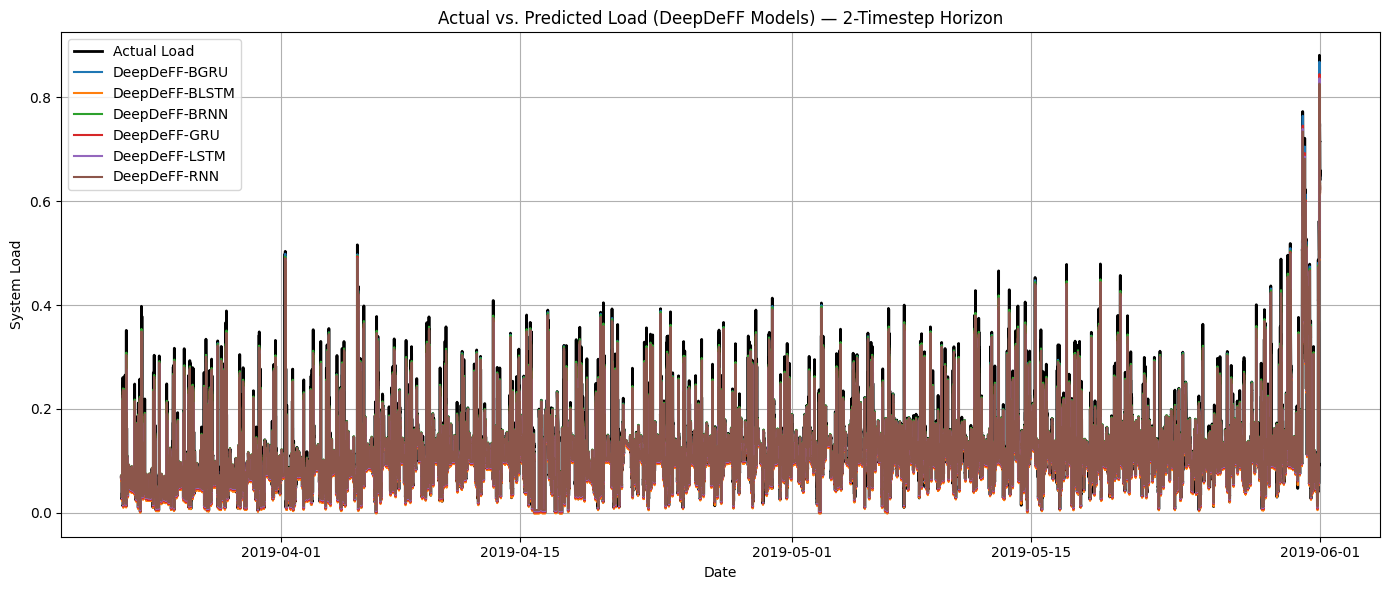

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Adjust these if your test target values were scaled
# (Assuming y_test is still in scaled format and you used MinMaxScaler)
# Inverse transform if needed
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Adjust test_dates if needed
sequence_dates = df.index[timesteps:]  # Offset due to sequence creation
test_dates = sequence_dates[int(0.8 * len(sequence_dates)):]
min_len = min(len(test_dates), len(y_test_original))

# Trim to match lengths
test_dates = test_dates[:min_len]
y_test_original = y_test_original[:min_len]

# Initialize DataFrame with actual load
plot_df = pd.DataFrame({'Actual Load': y_test_original}, index=test_dates)

# Add DeepDeFF predictions
for model_name, preds in predictions_dict_all['DeepDeFF'].items():
    preds = preds[:min_len]
    preds_original = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    plot_df[model_name] = preds_original

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(plot_df.index, plot_df['Actual Load'], label='Actual Load', linewidth=2, color='black')

for model_name in predictions_dict_all['DeepDeFF'].keys():
    plt.plot(plot_df.index, plot_df[model_name], label=model_name)

plt.title("Actual vs. Predicted Load (DeepDeFF Models) — 2-Timestep Horizon")
plt.xlabel("Date")
plt.ylabel("System Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
